In [5]:
import pandas as pd
import h3.api.numpy_int as h3

import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from shapely.geometry import Polygon, Point
import seaborn as sns
import re

import stc_unicef_cpi.data.get_satellite_data as ge
import stc_unicef_cpi.data.make_dataset as md
import stc_unicef_cpi.utils.general as g
import stc_unicef_cpi.utils.constants as c

import stc_unicef_cpi.utils.geospatial as geo
import stc_unicef_cpi.utils.clean_text as ct
import stc_unicef_cpi.utils.model_utils as mu

In [2]:
read_path = '/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data'

In [ ]:
raw = pd.read_csv(read_path + '/raw/childpoverty_microdata_gps_21jun22.csv')

/tmp/ipykernel_354/2679583450.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(read_path + '/raw/childpoverty_microdata_gps_21jun22.csv')


In [3]:
hexes_dhs = pd.read_csv(read_path + '/processed/20221102_hexes_dhs.csv', dtype={'hex_code':int})
hexes_dhs.shape

/tmp/ipykernel_761/1532314605.py:1: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  hexes_dhs = pd.read_csv(read_path + '/processed/20221102_hexes_dhs.csv', dtype={'hex_code':int})


(150212, 166)

In [4]:
pd.set_option("display.max_columns", 200)

In [13]:
def plot_africa(ax=None):
    shpfilename = shpreader.natural_earth(
            resolution="10m", category="cultural", name="admin_0_countries"
        )

    # read the shapefile using geopandas
    world = gpd.read_file(shpfilename)

    # select countries in Africa
    africa = world[world['CONTINENT'] == "Africa"]
    if ax==None:
        africa.plot(edgecolor="black", facecolor='lightgray', lw=0.25) 
    else:
        africa.plot(ax = ax, edgecolor="black", facecolor='lightgray', lw=0.25) 


In [11]:
def plot_country(country_code, ax=None):
    shpfilename = shpreader.natural_earth(
            resolution="10m", category="cultural", name="admin_0_countries"
        )

    # read the shapefile using geopandas
    world = gpd.read_file(shpfilename)

    # select countries in Africa
    country = world[world['ADM0_A3'] == country_code]
    if ax==None:
        country.plot(edgecolor="black", facecolor='lightgray', lw=0.25) 
    else:
        country.plot(ax = ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

In [12]:
def plot_subnational(country_code, ax=None):
    # Set up reader for this file
    shpfilename = shpreader.natural_earth(category='cultural', resolution='10m', name='admin_1_states_provinces')
    world_adm1 = gpd.read_file(shpfilename)

    # select countries in Africa
    country = world_adm1[world_adm1['adm0_a3'] == country_code]
    if ax==None:
        country.plot(edgecolor="black", facecolor='lightgray', lw=0.25) 
    else:
        country.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 


# Add hexcode to raw

In [85]:
raw.dropna(subset=['LATNUM'], inplace=True)
raw.shape

(2369393, 26)

In [86]:
raw = geo.get_hex_code(raw, 'LATNUM', 'LONGNUM', 7)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [87]:
raw['dep_2_or_more_sev'] = raw['sumpoor_sev']>1
raw['dep_3_or_more_sev'] = raw['sumpoor_sev']>2
raw['dep_4_or_more_sev'] = raw['sumpoor_sev']>3

In [88]:
dimensions = ['sumpoor_sev', 'dep_housing_sev', 'dep_water_sev',
       'dep_sanitation_sev', 'dep_nutrition_sev', 'dep_health_sev',
       'dep_education_sev', 'deprived_sev',
       'dep_2_or_more_sev', 'dep_3_or_more_sev', 'dep_4_or_more_sev']

In [89]:
dimensions_count = [re.sub('sev', 'count', dep) for dep in dimensions]
dic_rename = dict(zip(dimensions, dimensions_count))

In [90]:
grouped_count = raw.groupby('hex_code', as_index=False)[dimensions].agg('count')
grouped_count.rename(columns= dic_rename, inplace=True)


In [93]:
hexes_dhs = pd.merge(hexes_dhs, grouped_count, how='left', on='hex_code')
hexes_dhs.shape

(150271, 166)

In [94]:
hexes_dhs.head(2)

,hex_code,name_commuting,win_population_commuting,win_roads_km_commuting,area_commuting,n_conflicts,geometry,length_km,area_km2,road_density,avg_d_kbps,avg_u_kbps,GSM,LTE,UMTS,avg_signal,elevation,evapotrans,ndvi,ndwi,avg_rad,cf_cvg,pdsi,Optical_Depth_047,Optical_Depth_055,precimean,precistd,slope,2019gdp,africa,ec2019,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,child_pop,rwi,rwi_error,survey,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,latnum,longnum,dep_2_or_more_sev,dep_3_or_more_sev,dep_4_or_more_sev,hex_centroid,year_mean_neigh,round_mean_neigh,cluster_mean_neigh,hhid_mean_neigh,indid_mean_neigh,location_mean_neigh,sex_mean_neigh,wealth_mean_neigh,wealthscore_mean_neigh,age_mean_neigh,hhweight_mean_neigh,sumpoor_prev_neigh,sumpoor_count_neigh,housing_prev_neigh,housing_count_neigh,water_prev_neigh,water_count_neigh,sanitation_prev_neigh,sanitation_count_neigh,nutrition_prev_neigh,nutrition_count_neigh,health_prev_neigh,health_count_neigh,education_prev_neigh,education_count_neigh,deprived_sev_mean_neigh,deprived_sev_count_neigh,region_mean_neigh,region2_mean_neigh,latnum_mean_neigh,longnum_mean_neigh,2_or_more_prev_neigh,2_or_more_count_neigh,3_or_more_prev_neigh,3_or_more_count_neigh,4_or_more_prev_neigh,4_or_more_count_neigh,precipiacc,cnfd,accessibility,accessibility_walking_only,population,M_0,M_1,M_5,M_10,M_15,M_30,M_20,M_25,M_35,M_40,M_45,M_50,M_55,M_60,M_70,M_75,M_65,M_80,F_0,F_1,F_5,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_60,F_50,F_55,F_65,F_70,F_75,F_80,country_code,country,NR,CDMA,hex_code_str,water_surface,no_built,build_2000_2014,build_1990_2000,build_1975_1990,build_prior_1975,largest,sumpoor_count,dep_housing_count,dep_water_count,dep_sanitation_count,dep_nutrition_count,dep_health_count,dep_education_count,deprived_count,dep_2_or_more_count,dep_3_or_more_count,dep_4_or_more_count
0,610276395859312639,cabinda,1.328792e+06,18139.152803,9605.344439,0.0,"((12.732904100477812, -4.623059167412168), (12...",10.689607,5.311200,2.012654,NaN,NaN,0.0,0.0,0.0,NaN,211.45454,727.532504,0.343543,0.282376,0.157719,2.329546,1382.3182,382.359320,274.391760,0.127455,0.148234,5.437882,NaN,0.001981,NaN,NaN,NaN,NaN,6.167462,-0.336534,0.228155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-4.615699589011692, 12.722683696731998)",2015.0,71.0,77.000000,13.196721,4.360656,2.0,1.557377,2.934426,25245.852459,6.770492,0.392661,1.327869,61.0,0.114754,61.0,0.770492,61.0,0.409836,61.0,0.000000,12.0,0.000000,15.0,0.054054,37.0,0.770492,61.0,1.0,NaN,-4.653519,12.731428,0.475410,61.0,0.081967,61.0,0.0,61.0,2987.668259,0.000000,11.793229,71.0,12.868066,0.188045,0.789752,0.823278,0.797216,0.688460,0.413089,0.560355,0.533317,0.298992,0.242842,0.194163,0.193840,0.205593,0.102158,0.040404,0.022762,0.092256,0.013325,0.188357,0.791061,0.881214,0.853318,0.736909,0.662420,0.630457,0.488330,0.353451,0.287074,0.178695,0.094020,0.178397,0.189214,0.084906,0.037185,0.020948,0.012264,AGO,Angola,NaN,NaN,87823260dffffff,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,610276262933430271,cabinda,1.328792e+06,18139.152803,9605.344439,0.0,"((12.219237535243943, -5.6090981921783225), (1...",37.112027,5.311707,6.986836,15717.0,6479.0,1.0,0.0,0.0,0.0,68.95238,646.698793,0.215418,0.079168,5.743694,4.614418,1458.4762,364.300402,260.929612,0.127418,0.126591,5.127139,NaN,0.043447,NaN,435346.72,346996.25,4316442.5,297.571244,0.716460,0.509262,229.0,2015.0,71.0,313.541485,14.218341,5.100437,1.0,1.480349,3.733624,88895.668122,7.161572,0.614931,0.484716,0.135371,0.063636,0.148472,0.0,0.035714,0.201342,0.388646,1.0,NaN,-5.599547,12.20373,0.09607,0.0,0.0,"(-5.601659871826836, 12.20904389095013)",2015.0,71.0,292.231527,14.064039,5.009852,1.0,1.507389,3.815271,95529.032020,7.600985,0.568976,0.426108,406.0,0.160099,406.0,0.035264,397.0,0

In [96]:
hexes_dhs.to_csv(read_path + '/processed/20221030_hexes_dhs.csv', index=False)

# Years of DHS surveys

In [12]:
countries_ssf = ['Angola', 
            'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
            'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, The Democratic Republic of the', 'Congo', "Côte d'Ivoire",
            'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 
            'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
            'Kenya', 
            'Lesotho', 'Liberia', 
            'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique',
            'Namibia', 'Niger', 'Nigeria',
            'Rwanda', 
            'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'Sudan', 'South Sudan', 
            'Tanzania, United Republic of', 'Togo', 
            'Uganda',
            'Zambia', 'Zimbabwe']

In [16]:
countries_dhs = pd.DataFrame(columns=['country', 'country_code', 'dhs_children', 'dhs_year', 'mics_children', 'mics_year'])

for country in countries_ssf:
    country_code = ct.get_alpha3_code(country)

    if country_code in list(raw['countrycode']):
        subset = raw[raw['countrycode']==country_code]
        # print('check if there are nan values')
        # print(subset['deprived_sev'].value_counts())
        dhs = subset[subset.survey=='DHS']
        if dhs.shape[0]!= 0:
            year_dhs = dhs.year.mean()
            num_dhs = dhs.shape[0]
        else:
            year_dhs, num_dhs = 0, 0

        mics = subset[subset.survey=='MICS']
        if mics.shape[0]!= 0:
            year_mics = mics.year.mean()
            num_mics = mics.shape[0]
        else:
            year_mics, num_mics = 0, 0

        countries_dhs = countries_dhs.append({'country':country,  'country_code':country_code, 'dhs_children': num_dhs, 'dhs_year':year_dhs, 
                    'mics_children':  num_mics,   'mics_year': year_mics}, ignore_index=True)
    
        

In [19]:
country_mics = countries_dhs[countries_dhs['mics_children']!= 0].copy()
countries_dhs = countries_dhs[countries_dhs['dhs_children']!= 0].copy()

In [23]:
country_mics

,country,country_code,dhs_children,dhs_year,mics_children,mics_year
5,Central African Republic,CAF,0,0.0,25430,2019.0
6,Chad,TCD,0,0.0,67164,2019.0
8,"Congo, The Democratic Republic of the",COD,53868,2013.0,57566,2018.0
9,Congo,COG,0,0.0,26691,2015.0
10,Côte d'Ivoire,CIV,0,0.0,28377,2016.0
11,Eswatini,SWZ,0,0.0,10131,2014.0
13,Gambia,GMB,0,0.0,32786,2018.0
14,Ghana,GHA,0,0.0,30663,2017.0
16,Guinea-Bissau,GNB,0,0.0,24206,2019.0
18,Lesotho,LSO,16898,2014.0,13989,2018.0


In [14]:
# countries_dhs = pd.read_csv('/mnt/c/Users/vicin/Desktop/DSSG/Data/Tables tesi/countries_with_output.csv', dtype = {'DHS year':int})
# countries_dhs = countries_dhs.rename(columns = {'Country':'country', 'Code':'country_code', 'DHS year':'dhs_year', 'Number of children with DHS':'dhs_children'})
countries_dhs.head(3)

,country,country_code,dhs_children,dhs_year,num hex with output,num hex with neigh,tot
0,Angola,AGO,42167,2015,519,6050,220183
1,Benin,BEN,40064,2017,475,5065,28345
2,Burkina Faso,BFA,44464,2010,501,7154,67132


In [38]:
# ctry_code = ct.get_alpha3_code('')
shpfilename = shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )

# read the shapefile using geopandas
world = gpd.read_file(shpfilename)

# select countries in Africa
africa = world[world['CONTINENT'] == "Africa"]

In [4]:
africa.head(2)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
13,Admin-0 country,0,2,Ethiopia,ETH,0,2,Sovereign country,1,Ethiopia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((34.07070 9.45459, 34.06689 9.53118, ..."
14,Admin-0 country,0,3,South Sudan,SDS,0,2,Sovereign country,1,South Sudan,...,None,None,None,None,None,None,None,None,None,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ..."


In [5]:
to_plot = africa.merge(countries_dhs, how='left', right_on = 'country_code', left_on = 'ADM0_ISO')
to_plot = to_plot[to_plot.country_code.isna()==False].copy()
to_plot['dhs_year'] = to_plot['dhs_year'].apply(lambda x: int(x))
print(to_plot.shape)

(25, 176)


In [6]:
sorted(to_plot.dhs_year.unique())

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

Countries with DHS surveys and the latest year it was done


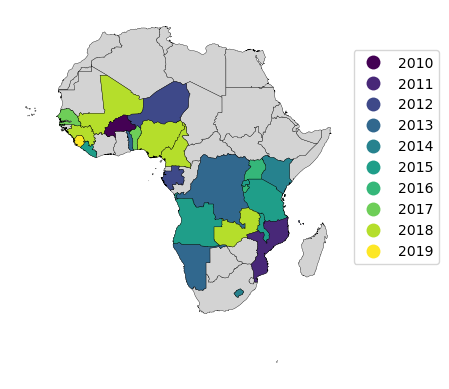

In [7]:
fig, ax = plt.subplots()# dpi=300)
ax.axis('off')

africa.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

print('Countries with DHS surveys and the latest year it was done')
_ = to_plot.plot(ax=ax, edgecolor="black", cmap = 'viridis', column = 'dhs_year',  lw=0.25, 
            categorical=True, legend=True,
            legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.6),
                         'fmt': "{:.0f}"}) 



Children surveys per country


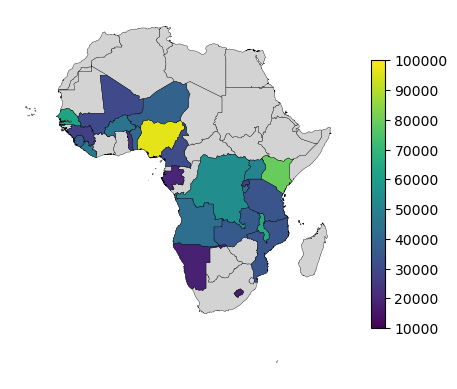

In [8]:
fig, ax = plt.subplots()# dpi=300)
ax.axis('off')

africa.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

vmin, vmax = 10000, 100000

print('Children surveys per country')
_ = to_plot.plot(ax=ax, edgecolor="black", cmap = 'viridis', column = 'dhs_children',  lw=0.25, vmin = vmin, vmax = vmax, 
            # legend=True,
            # legend_kwds={"shrink":.9},
            )

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)


# Correlation between dimensions

In [51]:
hexes_dhs_no_neigh = hexes_dhs[hexes_dhs['deprived_sev'].isna()==False].copy()
hexes_dhs_no_neigh.shape

(12468, 163)

In [13]:
dimensions = ['sumpoor_sev', 'dep_housing_sev', 'dep_water_sev',
       'dep_sanitation_sev', 'dep_nutrition_sev', 'dep_health_sev',
       'dep_education_sev', 'deprived_sev']
labels = ['depth', 'housing', 'water', 'sanitation', 'nutrition', 'health', 'education', 'prevalence']

In [11]:
corr_no_neigh = hexes_dhs_no_neigh[dimensions].corr()

<AxesSubplot:>

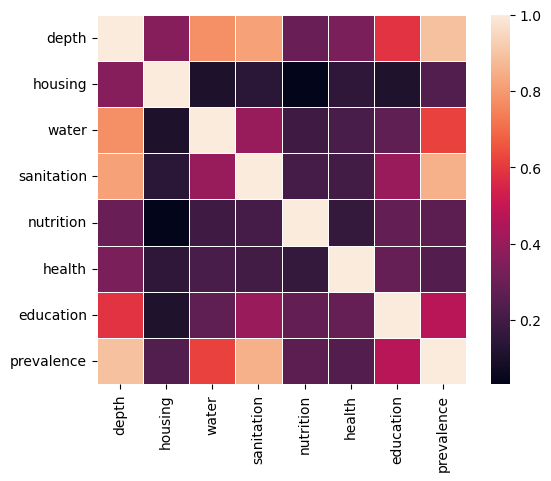

In [17]:
sns.heatmap(corr_no_neigh,
            square=True,
            xticklabels=labels, yticklabels=labels,
            linewidth=.5)

# Correlation btw input and output

In [6]:
corr_mat = hexes_dhs.corr()

In [29]:
dimensions = ['sumpoor_sev', 'dep_housing_sev',
 'dep_water_sev', 'dep_sanitation_sev', 'dep_nutrition_sev',
 'dep_health_sev', 'dep_education_sev', 'deprived_sev',
 'dep_2_or_more_sev']
#  , 'dep_3_or_more_sev', 'dep_4_or_more_sev']

In [121]:
# to_keep = []
# thr = 0.5
# for col in corr_mat.columns:
#     values = corr_mat[col]
#     values = values.drop(col)
#     mi, ma = values.min(), values.max()
#     if (mi < - thr) | (ma > thr):
#         # print(f'{col} - min: {corr_mat[col].min()}, max: {corr_mat[col].max()}')
#         to_keep.append(col)
# len(to_keep)

145

In [28]:
# sns.heatmap(corr_mat[to_keep])

In [8]:
input = ['win_population_commuting', 'win_roads_km_commuting',
       'area_commuting', 'n_conflicts', 'length_km', 'area_km2',
       'road_density', 'avg_d_kbps', 'avg_u_kbps', 'GSM', 'LTE', 'UMTS',
       'avg_signal', 'elevation', 'evapotrans', 'ndvi', 'ndwi', 'avg_rad',
       'cf_cvg', 'pdsi', 'Optical_Depth_047', 'Optical_Depth_055', 'precimean',
       'precistd', 'slope', '2019gdp', 'africa', 'ec2019', 'GDP_PPP_1990',
       'GDP_PPP_2000', 'GDP_PPP_2015', 'child_pop', 'rwi', 'rwi_error',
       'precipiacc',
       'cnfd', 'accessibility', 'accessibility_walking_only', 'population',
       'M_0', 'M_1', 'M_5', 'M_10', 'M_15', 'M_30', 'M_20', 'M_25', 'M_35',
       'M_40', 'M_45', 'M_50', 'M_55', 'M_60', 'M_70', 'M_75', 'M_65', 'M_80',
       'F_0', 'F_1', 'F_5', 'F_10', 'F_15', 'F_20', 'F_25', 'F_30', 'F_35',
       'F_40', 'F_45', 'F_60', 'F_50', 'F_55', 'F_65', 'F_70', 'F_75', 'F_80',
       'NR', 'CDMA', 'water_surface', 'no_built', 'build_2000_2014',
       'build_1990_2000', 'build_1975_1990', 'build_prior_1975',
       ]

In [9]:
len(input)

83

In [13]:
to_keep = []
thr = 0.30
for col in input:
    values = corr_mat.loc[str(col)][dimensions]
    mi, ma = values.min(), values.max()
    if (mi < - thr) | (ma > thr):
        print(f'{col} - min: {mi}, max: {ma}')
        to_keep.append(col)
len(to_keep)

win_roads_km_commuting - min: 0.0482993367024482, max: 0.327737593829499
area_commuting - min: 0.10523792921204517, max: 0.33973575270117734
length_km - min: -0.5025059780719392, max: -0.036144486295960676
road_density - min: -0.504004970641339, max: -0.03218645942661038
ndwi - min: -0.35362857335527004, max: 0.09706612809106765
precistd - min: -0.31017950962006013, max: -0.0
africa - min: -0.41604662207820586, max: 0.005415776552446945
child_pop - min: -0.3086789521928439, max: 0.025773755286237685
rwi - min: -0.5601211725958284, max: -0.0
rwi_error - min: -0.4154656838745479, max: -0.0
precipiacc - min: -0.3058565220804788, max: 0.06048499415490104
cnfd - min: -0.42607685069296314, max: 0.0155663915144383
accessibility - min: 0.10121579756428346, max: 0.33530344544907825
accessibility_walking_only - min: 0.09942377256745918, max: 0.3132519168766838
population - min: -0.31186446315880256, max: 0.03146244243918755
M_0 - min: -0.30584687952805534, max: 0.02738139637291981
M_1 - min: -0.

40

<AxesSubplot:>

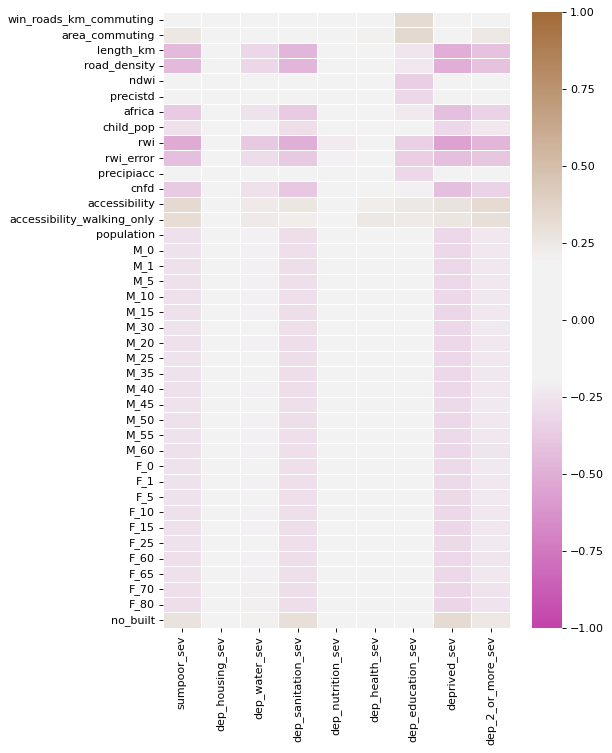

In [31]:
plt.figure(figsize=(7, 10), dpi=80)

cmap = sns.diverging_palette(320, 40, sep=50, as_cmap=True)

sns.heatmap(corr_mat.loc[to_keep][dimensions], cmap = cmap, vmin=-1, vmax=1, linewidths=0.5)

<AxesSubplot:>

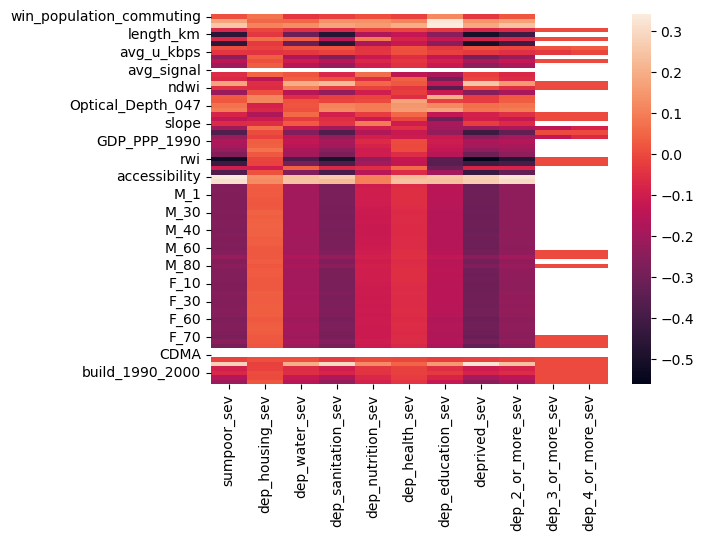

In [142]:
sns.heatmap(corr_mat.loc[input][dimensions])

In [159]:
hexes_dhs.columns[100:]

Index(['4_or_more_prev_neigh', '4_or_more_count_neigh', 'precipiacc', 'cnfd',
       'accessibility', 'accessibility_walking_only', 'population', 'M_0',
       'M_1', 'M_5', 'M_10', 'M_15', 'M_30', 'M_20', 'M_25', 'M_35', 'M_40',
       'M_45', 'M_50', 'M_55', 'M_60', 'M_70', 'M_75', 'M_65', 'M_80', 'F_0',
       'F_1', 'F_5', 'F_10', 'F_15', 'F_20', 'F_25', 'F_30', 'F_35', 'F_40',
       'F_45', 'F_60', 'F_50', 'F_55', 'F_65', 'F_70', 'F_75', 'F_80',
       'country_code', 'country', 'NR', 'CDMA', 'hex_code_str',
       'water_surface', 'no_built', 'build_2000_2014', 'build_1990_2000',
       'build_1975_1990', 'build_prior_1975', 'largest', 'sumpoor_count',
       'dep_housing_count', 'dep_water_count', 'dep_sanitation_count',
       'dep_nutrition_count', 'dep_health_count', 'dep_education_count',
       'deprived_count', 'dep_2_or_more_count', 'dep_3_or_more_count',
       'dep_4_or_more_count'],
      dtype='object')

# Missing values of dimensions

## no neigh

In [52]:
d = {}
for col in dimensions:
    col_count = re.sub('_sev', '_count', col)
    num_no_na = hexes_dhs_no_neigh[(hexes_dhs_no_neigh[col].isna()==False) & (hexes_dhs_no_neigh[col_count]>30)].shape[0]
    d[col] = num_no_na

/tmp/ipykernel_354/642795611.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(labels)


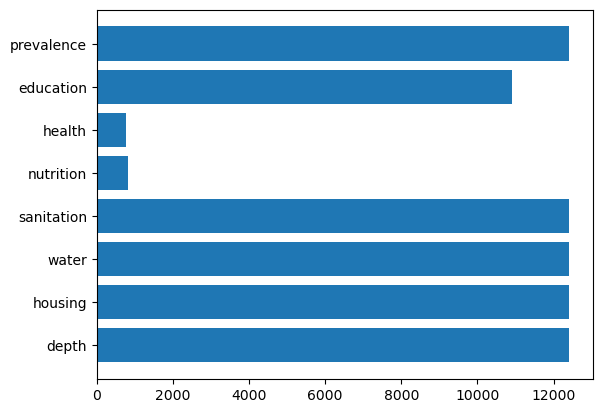

In [60]:
fig, ax = plt.subplots()# dpi=300)

plt.barh(list(d.keys()), list(d.values()))
_ = ax.set_yticklabels(labels)


## neigh

In [66]:
dimensions_neigh = ['sumpoor_prev_neigh',
       'housing_prev_neigh','water_prev_neigh',
       'sanitation_prev_neigh',
       'nutrition_prev_neigh', 'health_prev_neigh',
       'education_prev_neigh',
       'deprived_sev_mean_neigh']

In [68]:
d_neigh = {}
for col in dimensions_neigh:
    col_count = re.sub('(prev|mean)', 'count', col)
    num_no_na = hexes_dhs[(hexes_dhs[col].isna()==False) & (hexes_dhs[col_count]>30)].shape[0]
    d_neigh[col] = num_no_na

/tmp/ipykernel_354/608238936.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(labels)


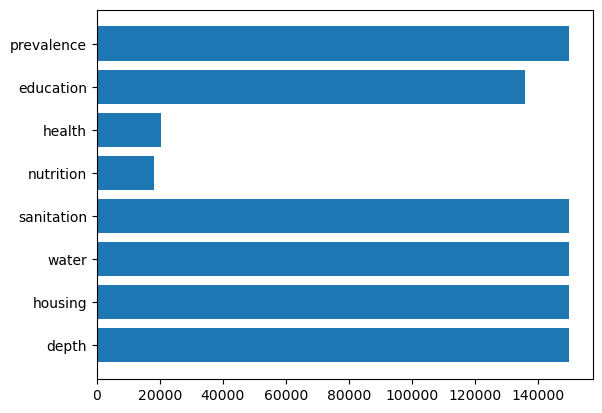

In [69]:
fig, ax = plt.subplots()# dpi=300)

plt.barh(list(d_neigh.keys()), list(d_neigh.values()))
_ = ax.set_yticklabels(labels)


# Distribution of output

[Text(0.5, 0, 'Education')]

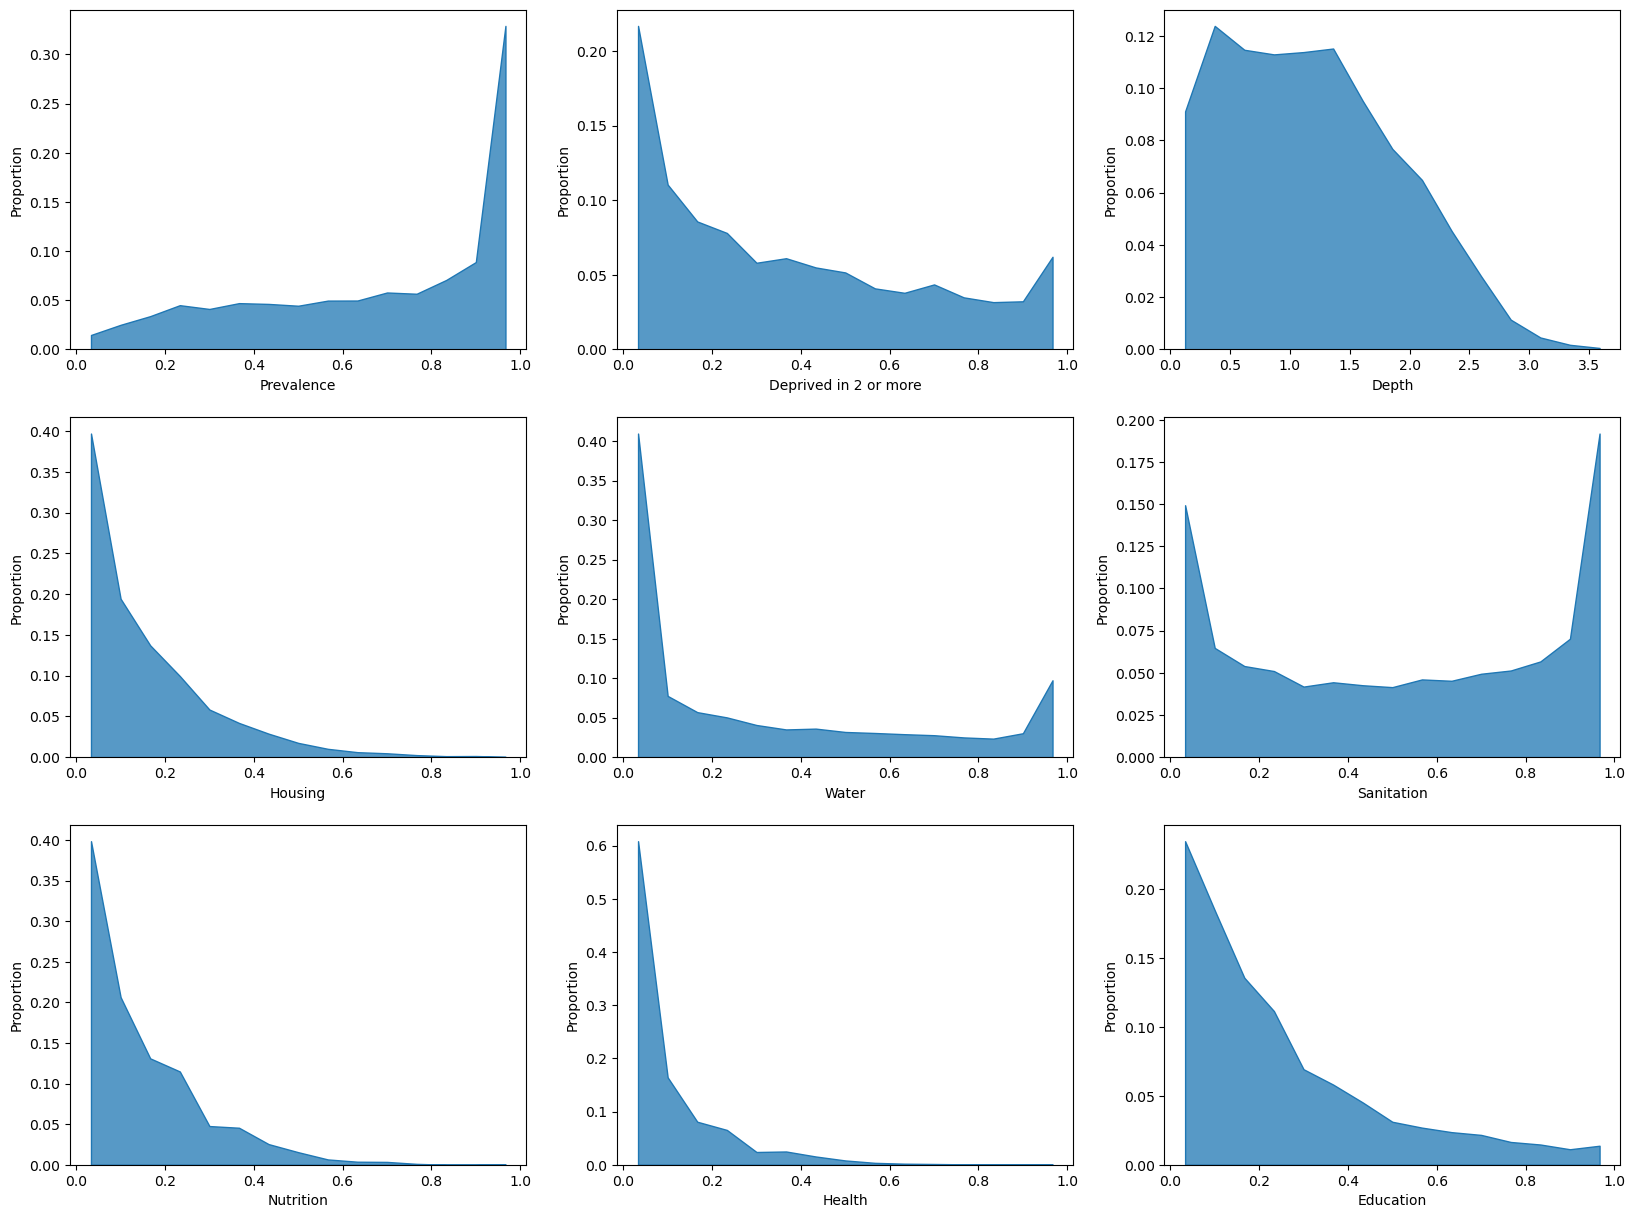

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

stat = 'proportion'
bins = 15
elem = 'poly'

fig, axs = plt.subplots(figsize=(20,15), nrows = 3, ncols=3)
ax00 = sns.histplot(hexes_dhs['deprived_sev'], stat=stat, bins = bins, element= elem, ax=axs[0, 0]).set(xlabel='Prevalence')

sns.histplot(hexes_dhs['dep_2_or_more_sev'], stat=stat, bins = bins, element= elem, ax=axs[0, 1]).set(xlabel='Deprived in 2 or more')
sns.histplot(hexes_dhs['sumpoor_sev'], stat=stat, bins = bins, element= elem, ax=axs[0, 2]).set(xlabel='Depth')

sns.histplot(hexes_dhs['dep_housing_sev'], stat=stat, bins = bins, element= elem, ax=axs[1, 0]).set(xlabel='Housing')
sns.histplot(hexes_dhs['dep_water_sev'], stat=stat, bins = bins, element= elem, ax=axs[1, 1]).set(xlabel='Water')
sns.histplot(hexes_dhs['dep_sanitation_sev'], stat=stat, bins = bins, element= elem, ax=axs[1,2]).set(xlabel='Sanitation')

sns.histplot(hexes_dhs['dep_nutrition_sev'], stat=stat, bins = bins, element= elem, ax=axs[2,0]).set(xlabel='Nutrition')
sns.histplot(hexes_dhs['dep_health_sev'], stat=stat, bins = bins, element= elem, ax=axs[2,1]).set(xlabel='Health')
sns.histplot(hexes_dhs['dep_education_sev'], stat=stat, bins = bins, element= elem, ax=axs[2,2]).set(xlabel='Education')

[Text(0.5, 0, 'Education')]

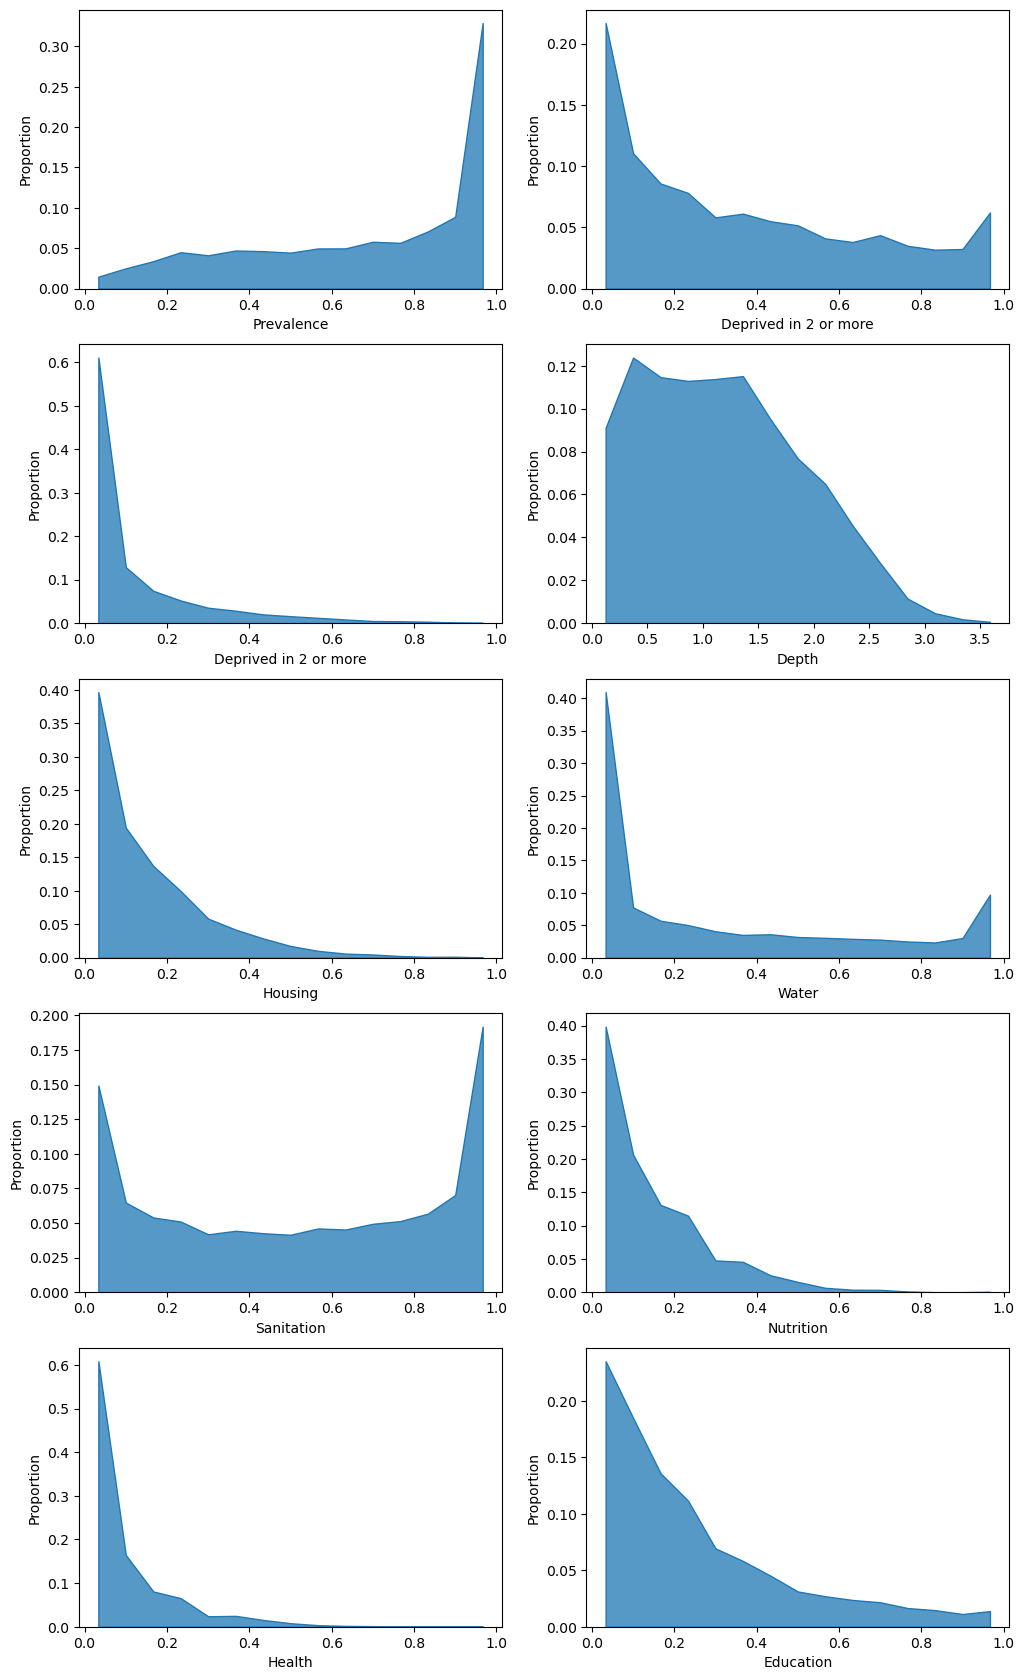

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

stat = 'proportion'
bins = 15
elem = 'poly'

fig, axs = plt.subplots(figsize=(12,21), nrows = 5, ncols=2)
ax00 = sns.histplot(hexes_dhs['deprived_sev'], stat=stat, bins = bins, element= elem, ax=axs[0, 0]).set(xlabel='Prevalence')
sns.histplot(hexes_dhs['dep_2_or_more_sev'], stat=stat, bins = bins, element= elem, ax=axs[0, 1]).set(xlabel='Deprived in 2 or more')

sns.histplot(hexes_dhs['dep_3_or_more_sev'], stat=stat, bins = bins, element= elem, binrange = (0,1), ax=axs[1, 0]).set(xlabel='Deprived in 2 or more')
sns.histplot(hexes_dhs['sumpoor_sev'], stat=stat, bins = bins, element= elem, ax=axs[1, 1]).set(xlabel='Depth')

sns.histplot(hexes_dhs['dep_housing_sev'], stat=stat, bins = bins, element= elem, ax=axs[2, 0]).set(xlabel='Housing')
sns.histplot(hexes_dhs['dep_water_sev'], stat=stat, bins = bins, element= elem, ax=axs[2, 1]).set(xlabel='Water')

sns.histplot(hexes_dhs['dep_sanitation_sev'], stat=stat, bins = bins, element= elem, ax=axs[3,0]).set(xlabel='Sanitation')
sns.histplot(hexes_dhs['dep_nutrition_sev'], stat=stat, bins = bins, element= elem, ax=axs[3,1]).set(xlabel='Nutrition')

sns.histplot(hexes_dhs['dep_health_sev'], stat=stat, bins = bins, element= elem, ax=axs[4,0]).set(xlabel='Health')
sns.histplot(hexes_dhs['dep_education_sev'], stat=stat, bins = bins, element= elem, ax=axs[4,1]).set(xlabel='Education')

# Hexcode in Nigeria

In [27]:
nga = hexes_dhs[hexes_dhs.country_code == 'NGA'].copy()
nga.shape

(16678, 166)

In [28]:
nga = geo.get_hex_centroid(nga)

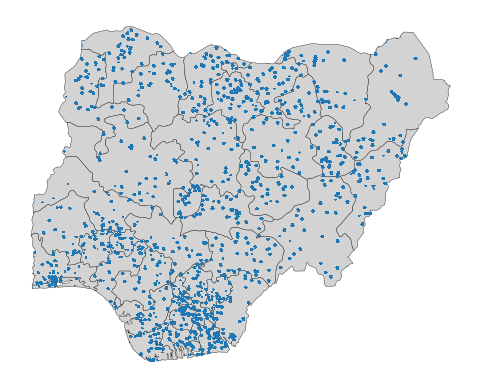

In [31]:
fig, ax = plt.subplots()# dpi=300)
ax.axis('off')

plot_subnational('NGA', ax=ax)
# nga_shp.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

plt.plot(nga['long'], nga['lat'], ',')

plt.show()

# Spatial Cross Validation

In [40]:
country_code = 'NGA'

In [33]:
ben_neigh_train, ben_neigh_test = X_train, X_test

In [41]:
# select country
df = mu.get_data_country(hexes_dhs, country_code, col='deprived_count')

# drop country code
X, Y = df, df
XY = df
print(X.shape)

X_train, X_test, Y_all_train, Y_all_test = mu.select_eval_split_type(X, Y, eval_split_type='normal', test_size=0.2)
print(X_train.shape)
print(X_test.shape)

kfold, spatial_groups = mu.select_cv_type(cv_type='spatial', nfolds=5, XY=XY, X_train=X_train)

(1284, 166)
(1027, 166)
(257, 166)


In [42]:
X_train['spatial_groups'] = list(spatial_groups)

In [43]:
# get lat and long
X_train = geo.get_hex_centroid(X_train, hex_code="hex_code")
X_test = geo.get_hex_centroid(X_test, hex_code="hex_code")

<AxesSubplot:xlabel='long', ylabel='lat'>

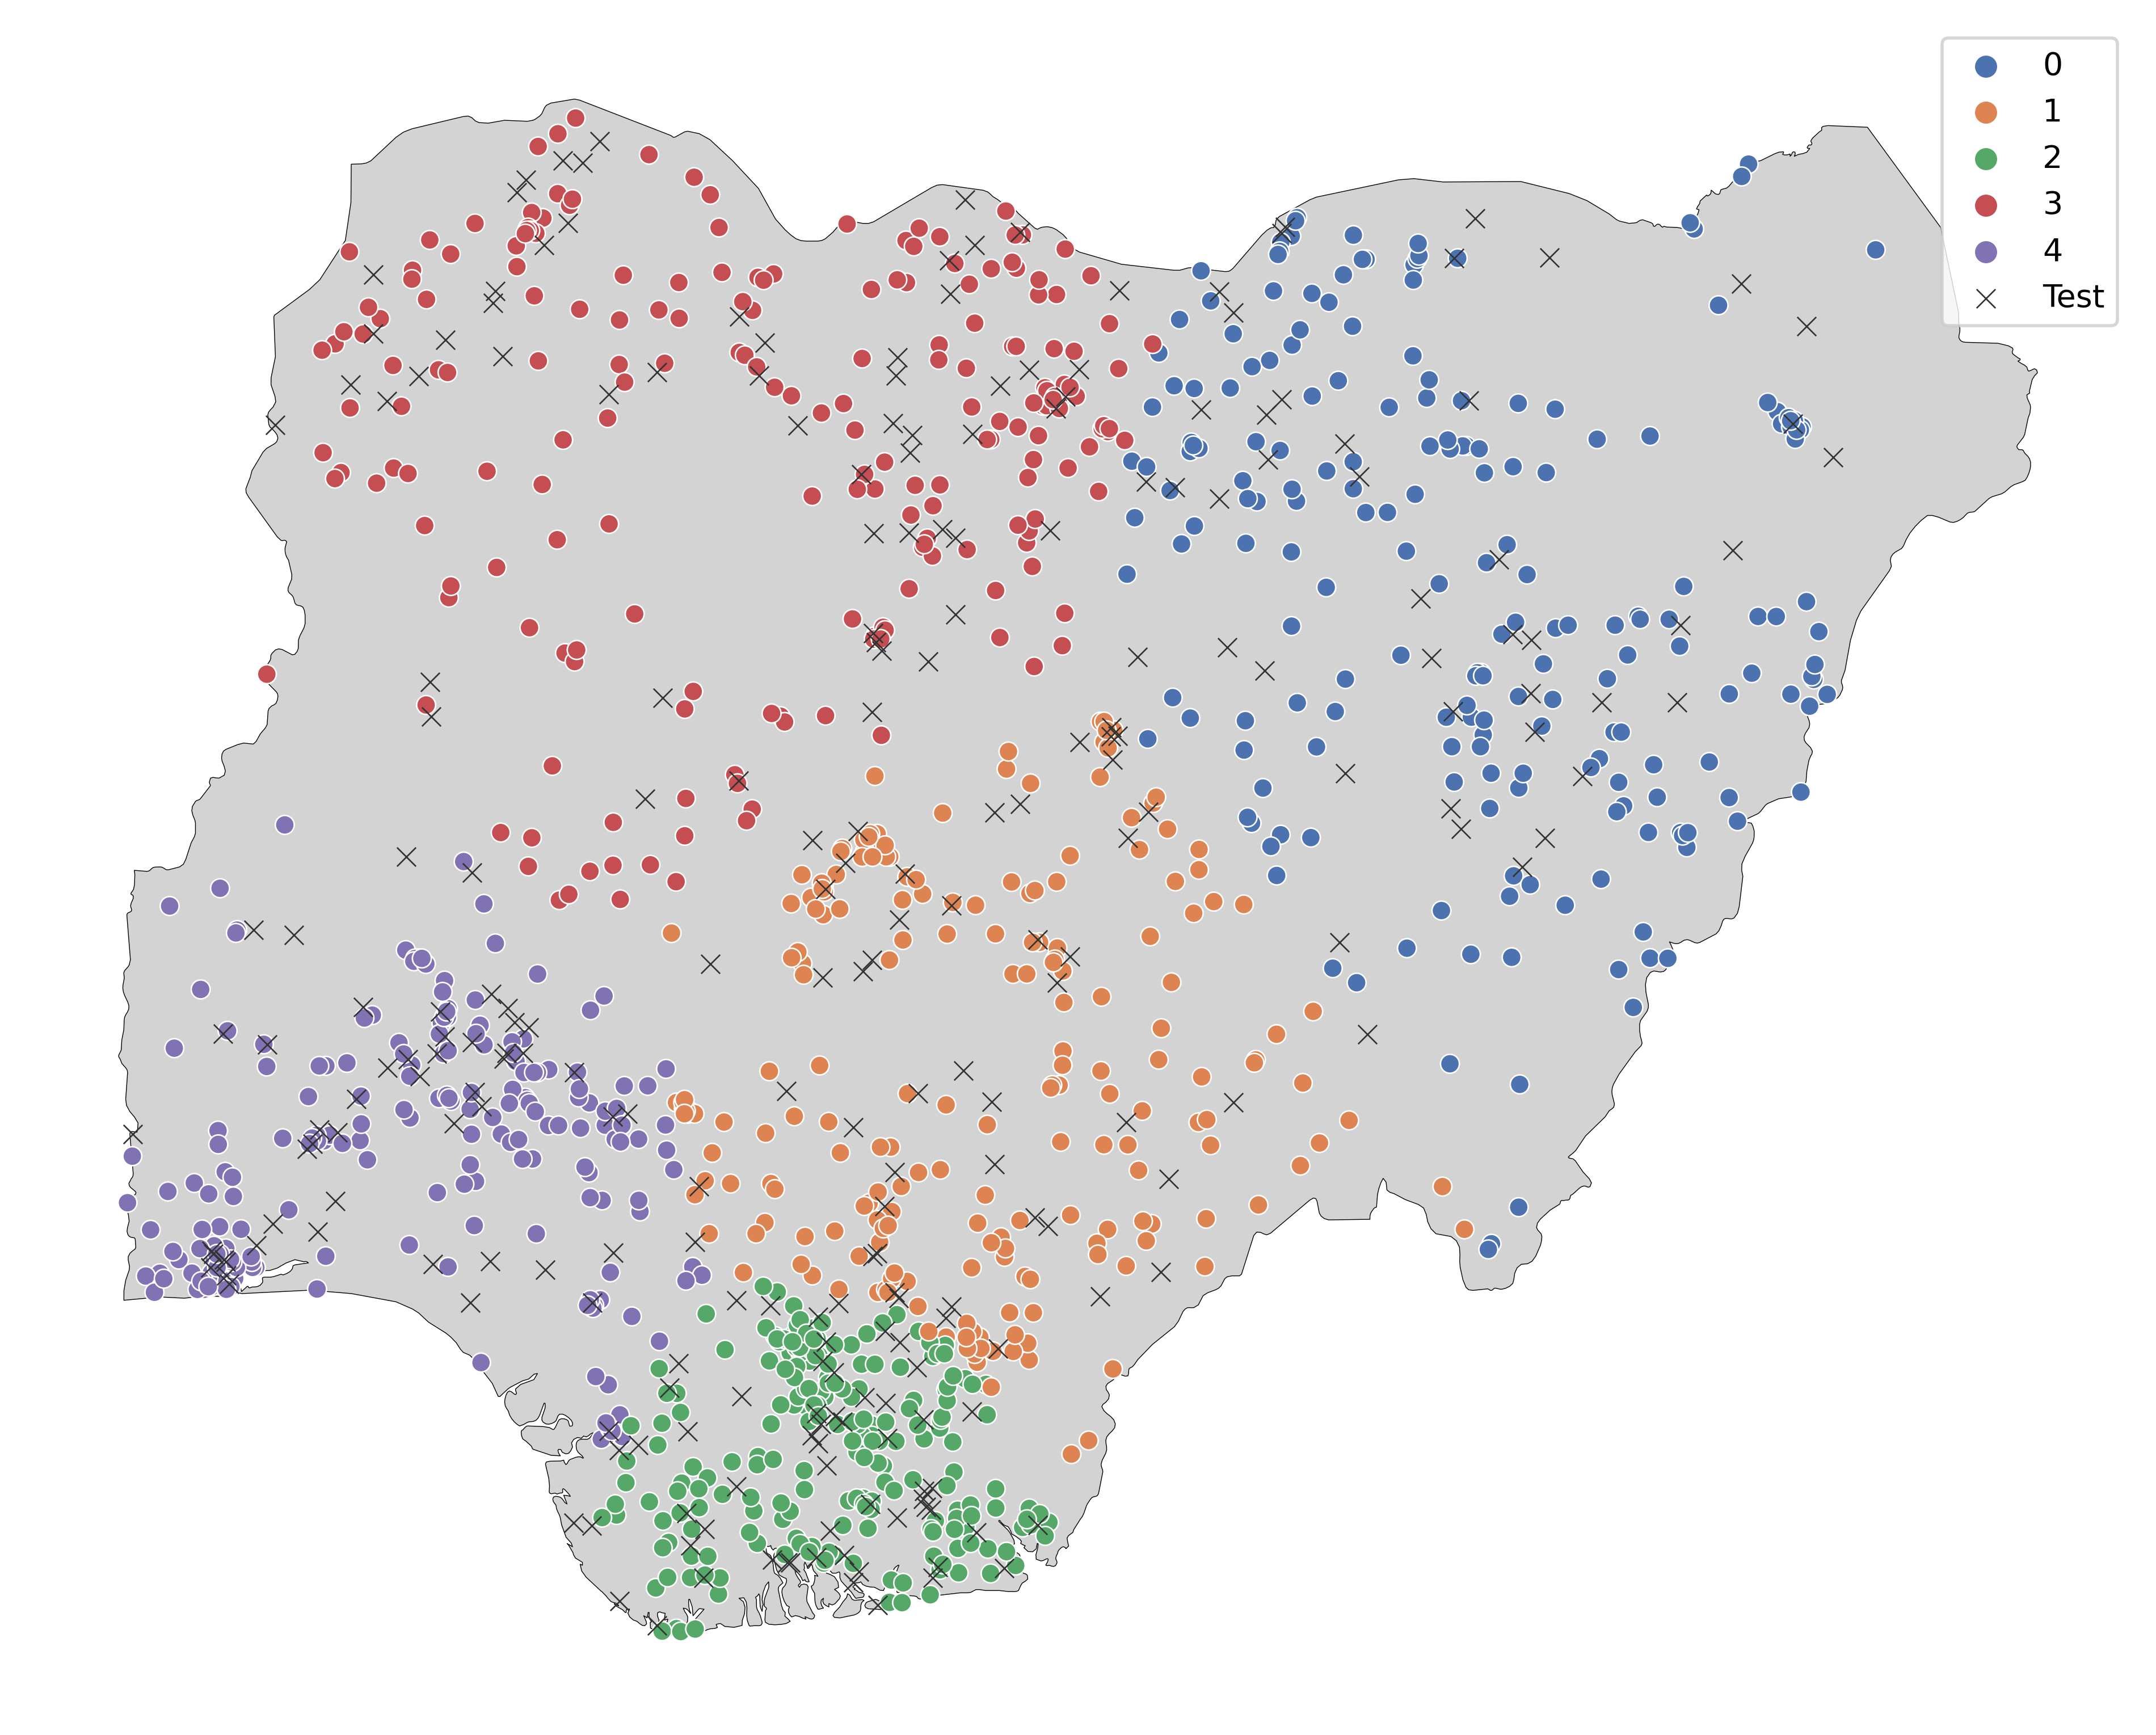

In [49]:
fig, ax = plt.subplots(figsize=(12, 10), dpi=400)

ax.grid(False)
plt.axis('off')
ax.set_facecolor('white')

plot_country(country_code, ax=ax)
sns.scatterplot(ax=ax, x="long", y="lat", hue="spatial_groups", data=X_train, palette='deep') #, hue_order=hue_order, kind="bar")
sns.scatterplot(ax=ax, x="long", y="lat", data=X_test, color=".2", marker="x", label = 'Test') #, hue_order=hue_order, kind="bar")

# plt.title(country_code)

# Results Experiment 1